In [45]:
import pandas as pd, numpy as np, seaborn as sns, geopandas as gpd, matplotlib.pyplot as plt
import matplotlib

from shapely.geometry import Point, mapping
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import cityImage as ci, ABManalysis as af

#libraries for clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

### Preparing and cleaning the routes

In [46]:
city_name = 'Muenster'
epsg = 25832
crs = 'EPSG:'+str(epsg)

## Import cleaned split routes and raw responses table

In [47]:
survey_routes = gpd.read_file("Outputs/split.shp")

In [48]:
raw = pd.read_csv("Input/resultsSurvey.csv") # raw responses
raw['startdate'] = raw.apply(lambda row: row['startdate'][11:], axis = 1)
raw['datestamp'] = raw.apply(lambda row: row['datestamp'][11:], axis = 1)
raw['duration'] = raw.apply(lambda row: af.compute_duration(row['startdate'], row['datestamp']), axis = 1)    
raw['PD2'] = raw['PD2'].fillna(raw['PD2'].mean())
raw['age'] = raw['PD2'].astype(int)
len(raw)

418

In [49]:
# cleaning
raw = raw[raw['duration']>= 20].copy()
print('nr participants '+str(len(raw)))
limit = {'A1':18, 'A2':25, 'A3':33, 'A4':41, 'A5':49, 'A6':57, 'A7':65, 'A8':73, 'A9':150}
raw['limit'] = raw[~raw.FQ1.isnull()].apply(lambda row: limit[row['FQ1']], axis = 1)
print("age issue", len(raw[~raw.FQ1.isnull()][['PD2', 'FQ1', 'limit']][raw.age > raw.limit]) + 
      len(raw[~raw.FQ1.isnull()][['PD2', 'FQ1', 'limit']][raw.age < raw.limit-7]))

nr participants 301
age issue 0


### Demographic information

In [50]:
raw.rename(columns={"PD1": "sex"}, inplace = True)
values = ['A1', 'A2', 'A3', 'A4']
new_values = ["male", "female", "non-binary", "prefer not to"]
for n, value in enumerate(values):
    raw['sex'].replace(value, new_values[n], inplace = True)

In [51]:
N = len(raw)
print('nr female participants', len(raw[raw.sex == 'female']),'percentage:', round(len(raw[raw.sex == 'female'])/N*100,1))
print('nr male participants', len(raw[raw.sex == 'male']),'percentage:',round(len(raw[raw.sex == 'male'])/N*100,1))
print('nr not binary', len(raw[raw.sex == 'non-binary']),'percentage:',round(len(raw[raw.sex == 'non-binary'])/N*100,1))
print('nr prefer not to', len(raw[raw.sex == 'prefer not to']),'percentage:', 
      round(len(raw[raw.sex == 'prefer not to'])/N*100,1))
print('mean age particpants', raw.age.mean())
print()
print('< 18 ', len(raw[raw.age < 18]),'percentage:', len(raw[raw.age < 18])/N*100)
print('nr 18 - 25', len(raw[(raw.age >= 18) & (raw.age <= 25)]),'percentage:', 
      round(len(raw[(raw.age >= 18) & (raw.age <= 25)])/N*100,1))
print('nr 26 - 33', len(raw[(raw.age >= 26) & (raw.age <= 33)]),'percentage:', 
      round(len(raw[(raw.age >= 26) & (raw.age <= 33)])/N*100,1))
print('nr 34 - 41', len(raw[(raw.age >= 34) & (raw.age <= 41)]),'percentage:', 
      round(len(raw[(raw.age >= 34) & (raw.age <= 41)])/N*100,1))
print('nr 42 - 49', len(raw[(raw.age >= 42) & (raw.age <= 49)]),'percentage:', 
      round(len(raw[(raw.age >= 42) & (raw.age <= 49)])/N*100,1))
print('nr 50 - 57', len(raw[(raw.age >= 50) & (raw.age <= 57)]),'percentage:', 
      round(len(raw[(raw.age >= 50) & (raw.age <= 57)])/N*100,1))
print('nr 58 - 65', len(raw[(raw.age >= 58) & (raw.age <= 65)]),'percentage:', 
      round(len(raw[(raw.age >= 58) & (raw.age <= 65)])/N*100,1))
print('nr 66 - 73', len(raw[(raw.age >= 66) & (raw.age <= 73)]),'percentage:', 
      round(len(raw[(raw.age >= 66) & (raw.age <= 73)])/N*100,1))
print('nr > 74', len(raw[(raw.age >= 74)]),'percentage:', round(len(raw[(raw.age >= 74)])/N*100,2))
print()   
print('mean duration', str(raw.duration.mean()))
print()

print(raw['age'].std())

nr female participants 188 percentage: 62.5
nr male participants 110 percentage: 36.5
nr not binary 2 percentage: 0.7
nr prefer not to 1 percentage: 0.3
mean age particpants 27.857142857142858

< 18  0 percentage: 0.0
nr 18 - 25 147 percentage: 48.8
nr 26 - 33 114 percentage: 37.9
nr 34 - 41 15 percentage: 5.0
nr 42 - 49 7 percentage: 2.3
nr 50 - 57 8 percentage: 2.7
nr 58 - 65 8 percentage: 2.7
nr 66 - 73 2 percentage: 0.7
nr > 74 0 percentage: 0.0

mean duration 53.68770764119601

9.352157886972243


In [52]:
print('nr tourists', len(raw[~raw['PD3[SQ001]'].isnull()]),'percentage:', round(len(raw[~raw['PD3[SQ001]'].isnull()])/N*100,1))
print('nr work', len(raw[~raw['PD3[SQ002]'].isnull()]),'percentage:', round(len(raw[~raw['PD3[SQ002]'].isnull()])/N*100,1))
print('nr living', len(raw[~raw['PD3[SQ003]'].isnull()]),'percentage:', round(len(raw[~raw['PD3[SQ003]'].isnull()])/N*100,1))
print('nr studying', len(raw[~raw['PD3[SQ004]'].isnull()]),'percentage:', round(len(raw[~raw['PD3[SQ004]'].isnull()])/N*100,1))
print('nr occasional', len(raw[~raw['PD3[SQ005]'].isnull()]),'percentage:', round(len(raw[~raw['PD3[SQ005]'].isnull()])/N*100,1))

nr tourists 1 percentage: 0.3
nr work 93 percentage: 30.9
nr living 200 percentage: 66.4
nr studying 255 percentage: 84.7
nr occasional 16 percentage: 5.3


## Reasons for Walking

In [53]:
columns = ['WB2[SQ001]', 'WB2[SQ002]','WB2[SQ003]','WB2[SQ004]','WB2[SQ005]']
labels = ['Commuting to/from work', 'Commuting to/from school/college/university', 'For social activities', 
          'For exercise or free-time activities', 'For other daily errands and commitments']
          
for column in columns: 
    raw[column].replace('A1', 1, inplace = True)
    raw[column].replace('A2', 2, inplace = True)
    raw[column].replace('A3', 3, inplace = True)
    raw[column].replace('A4', 4, inplace = True)
    raw[column].replace('A5', 5, inplace = True)

total_prob = 0.0
for n, column in enumerate(columns):
    prob = round(raw[column].mean(),3)
    total_prob += prob
    print(labels[n], round(raw[column].mean(),3))
    print("percentage ", round(raw[column].mean()*100/5,3))
    print()

Commuting to/from work 1.88
percentage  37.608

Commuting to/from school/college/university 2.465
percentage  49.302

For social activities 3.15
percentage  62.99

For exercise or free-time activities 3.535
percentage  70.698

For other daily errands and commitments 3.455
percentage  69.103



In [54]:
for n, column in enumerate(columns):
    actual_prob = round(raw[column].mean()/total_prob,2)
    print(labels[n], actual_prob)

Commuting to/from work 0.13
Commuting to/from school/college/university 0.17
For social activities 0.22
For exercise or free-time activities 0.24
For other daily errands and commitments 0.24


### Spatial Knowledge

<AxesSubplot:ylabel='Density'>

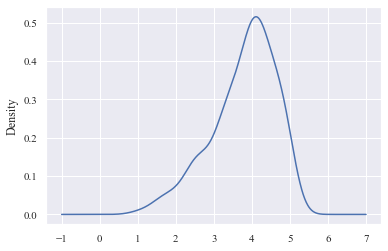

In [55]:
columns = ['WB4[SQ001]', 'WB4[SQ002]','WB4[SQ003]','WB4[SQ004]']
for column in columns: 
    raw[column].replace('A1', 1, inplace = True)
    raw[column].replace('A2', 2, inplace = True)
    raw[column].replace('A3', 3, inplace = True)
    raw[column].replace('A4', 4, inplace = True)
    raw[column].replace('A5', 5, inplace = True)
raw['knowledge'] = (raw['WB4[SQ001]'] + raw['WB4[SQ002]'] + raw['WB4[SQ003]'] +raw['WB4[SQ004]'])/4
raw['knowledge'].plot.kde()

## Preference and Aversion Barriers

In [56]:
columns = ['SP4[SQ002]', 'SP4[SQ006]','SP4[SQ001]','SP4[SQ005]']
for column in columns: 
    raw[column].replace('A1', 0.00, inplace = True)
    raw[column].replace('A2', 0.25, inplace = True)
    raw[column].replace('A3', 0.50, inplace = True)
    raw[column].replace('A4', 0.75, inplace = True)
    raw[column].replace('A5', 1.00, inplace = True)

raw['preferenceNatural'] = (raw['SP4[SQ002]'] + raw['SP4[SQ006]'])/2
raw['aversionSevering'] = raw['SP4[SQ001]']

## Further checks and preprocessing

In [57]:
def check(index):
    response = list(raw[to_check].loc[index][raw[to_check].loc[index].notna()])
    percentageA1 = response.count("A1")/len(response)
    percentageA2 = response.count("A2")/len(response)
    if ((percentageA1 > 0.65) | (percentageA2 > 0.65)) & (raw.loc[index].duration < 30):
        return True
    return False

In [58]:
# checking videos
vd_col = [col for col in raw if col.startswith('VD')]
to_remove = ['VD000a','VD000','VD099[SQ001]', 'VD100a', 'VD100', 'VD199[SQ001]','VD200a','VD200', 'VD299[SQ001]']
to_check = [item for item in vd_col if item not in to_remove]
raw['allSame'] = raw.apply(lambda row: check(row.name), axis = 1)
# raw[raw['allSame'] == True][['duration', 'age']]

In [59]:
columns = ['id'] + vd_col
columns = [item for item in columns if item not in to_remove]
responses = raw[columns].copy()

In [60]:
# clean columns and prepare an easy df to read
for column in responses.columns:
    if column == 'id':
        continue
    responses.rename({column: column[2:]}, axis=1, inplace = True)
    
for column in responses.columns:
    if column == 'id':
        continue
    if ('a' in column) | ('b' in column): continue
    new_column = '-'.join(column[i:i+3] for i in range(0, len(column), 3))
    responses.rename({column: new_column}, axis=1, inplace = True)
    
responses.rename({'150a151152': '150a-151-152'}, axis=1, inplace = True)
responses.rename({'150b126': '150b-126'}, axis=1, inplace = True)

In [61]:
summary = pd.DataFrame(columns = ['id']+list(survey_routes.video.unique()))
del summary[None]

summary = summary.reindex(sorted(summary.columns), axis=1)

for row in responses.itertuples():
    sectors = responses.loc[row.Index].notna().dot(responses.columns+',').rstrip(',')
    sectors = sectors.replace('-', ',')
    sectors_list = sectors.strip('').split(',')
    for sector in sectors_list:
        summary.at[row.Index, sector] = 1
        summary.at[row.Index, 'id'] = responses.loc[row.Index].id
        
summary.drop('114', inplace = True, axis = 1)
summary.fillna(0, inplace = True)
for column in summary.columns: 
    summary.rename(columns={column: str(column)}, inplace = True)
    
video0 = [col for col in summary if col.startswith('0')]
video1 = [col for col in summary if col.startswith('1')]
video2 = [col for col in summary if col.startswith('2')]
videos = [video0, video1, video2]

## Computing statistics

In [62]:
survey_routes['routeChoice'] = survey_routes.apply(lambda row: row['routeChoic'].replace(" ",""), axis = 1)
survey_routes['routeChoice'] = survey_routes.apply(lambda row: row['routeChoice'].strip('][').split(','), axis = 1)
survey_routes.drop('routeChoic', inplace = True, axis =1)

In [63]:
route_variables = ['usingElements', 'noElements','onlyDistance', 'onlyAngular', 'distanceHeuristic', 'angularHeuristic', 
                   'regions', 'routeMarks', 'barriers','distantLandmarks', 'preferenceNatural', 'aversionSevering']
other_variables = ["length", "minimisation_length","combined_length"]
routes_stats = af.set_routes_stats(summary, survey_routes, videos)

In [64]:
raw.index = raw['id']
routes_stats.index.name = None
routes_stats['preferenceNatural'] = raw['preferenceNatural']
routes_stats['aversionSevering'] = raw['aversionSevering']
routes_stats['knowledge'] = raw['knowledge']
routes_stats.head(10)

,onlyDistance,onlyAngular,distanceHeuristic,angularHeuristic,regions,routeMarks,barriers,distantLandmarks,usingElements,noElements,length,combined_length,minimisation_length,preferenceNatural,aversionSevering,knowledge
9,0.562,0.438,0.638,0.362,0.273,0.165,0.529,0.621,0.695,0.305,4347.289,3582.347,1432.933,0.500,0.750,4.500
10,0.64,0.36,0.548,0.452,0.323,0.328,0.456,0.59,0.612,0.388,4224.494,3580.186,2216.425,0.750,0.750,4.000
13,0.555,0.445,0.612,0.388,0.371,0.21,0.574,0.711,0.695,0.305,4291.776,4291.756,2142.342,0.125,0.250,4.750
14,0.696,0.304,0.474,0.526,0.461,0.321,0.32,0.687,0.622,0.378,5005.314,4171.568,2344.756,0.750,1.000,3.500
15,0.492,0.508,0.629,0.371,0.373,0.431,0.378,0.49,0.635,0.365,4339.647,2988.757,1597.901,0.750,0.750,4.250
17,0.659,0.341,0.625,0.375,0.28,0.254,0.462,0.757,0.637,0.363,4316.350,3919.428,2243.072,0.375,0.500,3.250
19,0.624,0.376,0.562,0.438,0.516,0.155,0.475,0.513,0.745,0.255,4479.973,4479.953,1770.501,0.375,0.750,4.750
20,0.596,0.404,0.518,0.482,0.61,0.74,0.102,0.131,0.59,0.41,4670.991,3742.692,2700.807,0.375,0.250,4.000
22,0.696,0.304,0.485,0.515,0.458,0.352,0.295,0.719,0.639,0.361,4864.052,4146.069,2344.756,0.500,0.500,4.500
24,0.412,0.588,0.634,0.366,0.368,0.611,0.389,0.22,0.681,0.319,4454.943,4058.041,2239.914,0.500,0.500,4.750


## Cluster Analysis

In [65]:
cluster_variables =  ['onlyDistance', 'onlyAngular', 'distanceHeuristic', 'angularHeuristic', 'regions', 
                      'routeMarks', 'barriers','distantLandmarks']

input_matrix = routes_stats[route_variables].copy()
input_matrix.replace(0.0, 0.01, inplace = True)
for column in cluster_variables:
    if column in ['onlyDistance', 'onlyAngular']:
        input_matrix[column] = input_matrix[column] * input_matrix['noElements']
    else:
        input_matrix[column] = input_matrix[column] * input_matrix['usingElements']

input_matrix = input_matrix.astype(float)

In [66]:
tab = pd.DataFrame(columns = {'variable', 'value'}) 
labels = ['using\nUE', 'only\nGMH', 'distance\nGMH', 'angular\nGMH', 'distance\nLMH', 'angular\nLMH', 'regions', 
          'on-route\nmarks', 'barriers', 'distant\nlandmarks', 'natural\nbarriers', 'severing\nbarriers']

tab = pd.DataFrame(columns = {'variable', 'value'}) 
index = 0
for subject in input_matrix.index:
    for n, variable in enumerate(route_variables):
        tab.at[index, 'variable'] = labels[n]
        tab.at[index, 'value'] = input_matrix.loc[subject][variable]
        index += 1

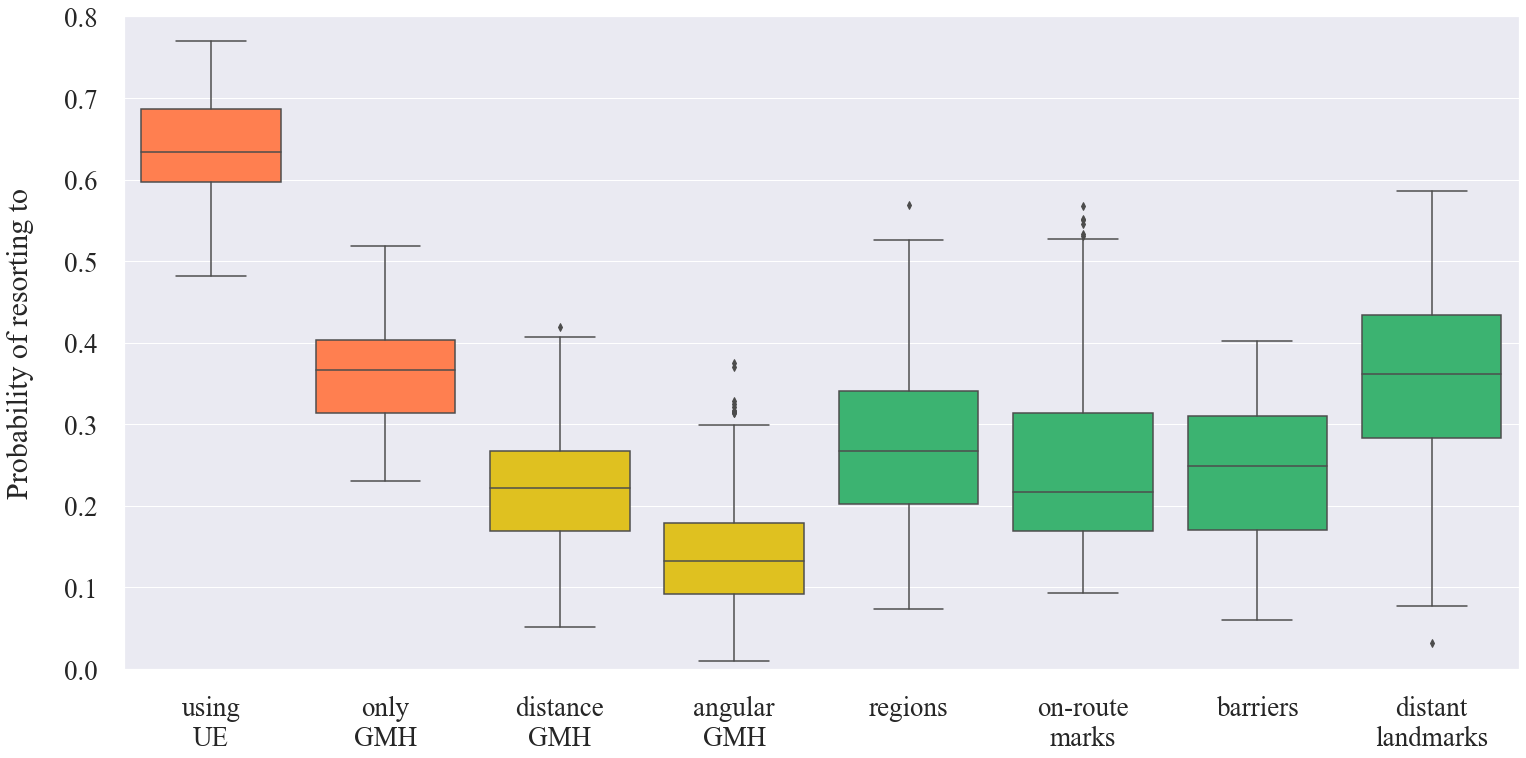

In [82]:
sns.set()
sns.set_color_codes()
palette = ['salmon']
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(25, 12))        

short = tab[~((tab.variable == "natural\nbarriers") | (tab.variable == "severing\nbarriers"))].copy()
short = short[~((short.variable == "distance\nLMH") | (short.variable == "angular\nLMH"))].copy()


ax = sns.boxplot(x="variable", y="value", data=short, palette = 'gold')
ax.set_ylim(0.0, 0.80)
ax.set_ylabel('Probability of resorting to', fontsize = 30, labelpad = 30, fontfamily = 'Times New Roman')
ax.set_xlabel('', labelpad = 30, fontfamily = 'Times New Roman')

for n, box in enumerate(ax.artists):
    if n < 2:
        box.set_facecolor('coral')
    if n > 3:
        box.set_facecolor('mediumseagreen')
    

for tick in ax.get_yticklabels(): 
    tick.set_fontname('Times New Roman')
for tick in ax.get_xticklabels(): 
    tick.set_fontname('Times New Roman')
ax.tick_params(axis='both', labelsize= 27, pad = 20)

In [83]:
fig.savefig("Outputs/Figures/empiricalABM/f4_conference.pdf", bbox_inches='tight')

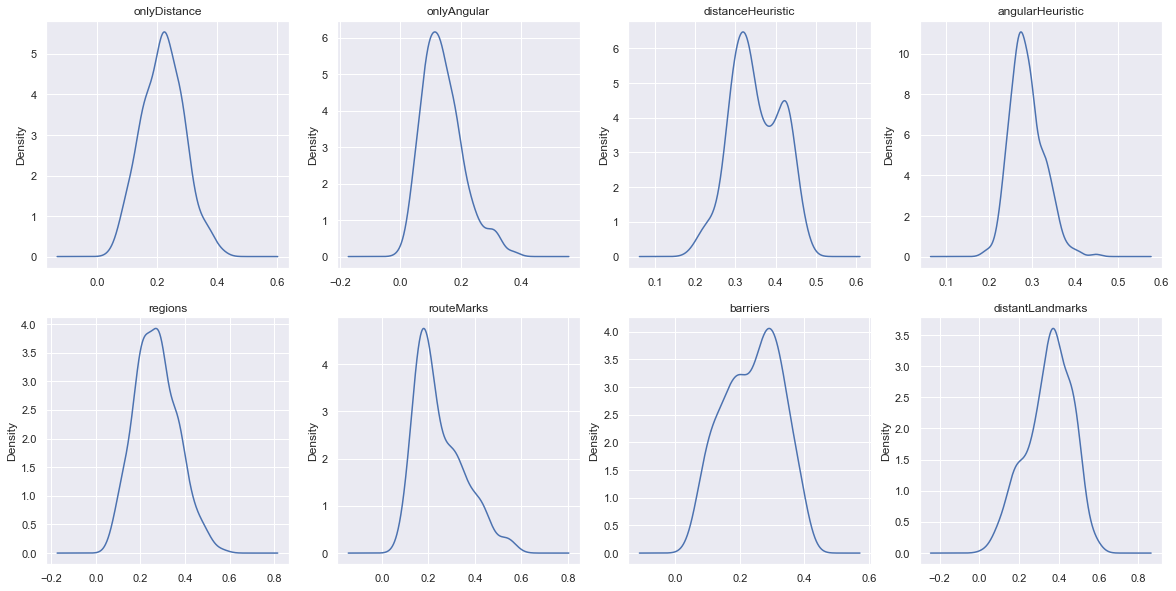

In [69]:
X = input_matrix[cluster_variables].copy()
fig = plt.figure(figsize = (20, 10))
for n, column in enumerate(list(X.columns)):
    ax = fig.add_subplot(2,4,n+1)
    ax = X[column].plot.kde(title = 'log')
    ax.set_title(column)

In [70]:
X_log = af.log_transf(input_matrix[element_variable])
X_log_stand = X_log.copy()
    
for column in X_log.columns:
    X_log_stand[column] = af.standardise_column(X_log, column)

In [71]:
list_scores = []

def pipe_kmeans(X_toFit):
    # done
    X_tmp = X_toFit.copy()
    for n_clusters in range(2, 10):
        clusterer = KMeans(n_clusters = n_clusters, n_init = 2000).fit(X_toFit)
        labels = clusterer.labels_
        score = round(silhouette_score(X_tmp, labels, metric= 'sqeuclidean'), 3)
        param_score = {'algorithm': 'k-means', 'n_clusters' : n_clusters, 'score' : score,
                       'clusterer' : clusterer}
        list_scores.append(param_score)

pipe_kmeans(X_log_stand)
clustering = pd.DataFrame(list_scores)
clustering.sort_values(by = 'score', ascending = False)

,algorithm,n_clusters,score,clusterer
0,k-means,2,0.543,"KMeans(n_clusters=2, n_init=2000)"
2,k-means,4,0.470,"KMeans(n_clusters=4, n_init=2000)"
1,k-means,3,0.442,"KMeans(n_clusters=3, n_init=2000)"
5,k-means,7,0.414,"KMeans(n_clusters=7, n_init=2000)"
4,k-means,6,0.395,"KMeans(n_clusters=6, n_init=2000)"
7,k-means,9,0.391,"KMeans(n_clusters=9, n_init=2000)"
6,k-means,8,0.382,KMeans(n_init=2000)
3,k-means,5,0.381,"KMeans(n_clusters=5, n_init=2000)"


In [2]:


# for variable in cluster_variables: 
#     print()
#     for other in cluster_variables: 
#         if other == variable: 
#             continue
#         print('correlation', variable,'and:', other, 
#               round(np.corrcoef(input_with_cluster[variable], input_with_cluster[other])[0][1], 3))

NameError: name 'pd' is not defined

In [ ]:
from scipy.stats import f_oneway

def pipe_kmeans_VCR(X):

    VRCs = []
    X_tmp = X.copy()
    X_toFit = X.copy()
    
    for n_clusters in range(2, 11):
        
        clusterer = KMeans(n_clusters = n_clusters, n_init = 2000).fit(X_toFit)
        X_tmp['cluster'] = clusterer.labels_

        f = 0.0
        for var in cluster_variables:
            arrays = []
            for cluster in list(X_tmp['cluster'].unique()):
                arrays.append(X_tmp[var+'_log'][X_tmp.cluster == cluster])
            
            if n_clusters == 2:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1])).statistic
            if n_clusters == 3:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2])).statistic
            if n_clusters == 4:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3])).statistic
            if n_clusters == 5:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
                          np.array(arrays[4])).statistic
            if n_clusters == 6:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
                          np.array(arrays[4]),np.array(arrays[5])).statistic
            if n_clusters == 7:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
                          np.array(arrays[4]),np.array(arrays[5]),np.array(arrays[6])).statistic
            if n_clusters == 8:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
                          np.array(arrays[4]),np.array(arrays[5]),np.array(arrays[6]),np.array(arrays[7])).statistic
            if n_clusters == 9:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
                          np.array(arrays[4]),np.array(arrays[5]),np.array(arrays[6]),np.array(arrays[7]),np.array(arrays[8])
                                    ).statistic
            if n_clusters == 10:
                statistic = f_oneway(np.array(arrays[0]), np.array(arrays[1]), np.array(arrays[2]), np.array(arrays[3]), 
                          np.array(arrays[4]),np.array(arrays[5]),np.array(arrays[6]),np.array(arrays[7]),np.array(arrays[8])
                                    ,np.array(arrays[9])).statistic
            
            f += statistic
        VRCs.append(f)   
    return VRCs

 
VRCs = pipe_kmeans_VCR(X_log_stand)

In [1023]:
for n, VRC in enumerate(VRCs):
    if (n == 0) | (n == len(VRCs)-1):
        continue
    index = (VRCs[n+1]-VRC)-(VRC-VRCs[n-1])
    print("structure with ", n+2, "clusters: Omega is", index, "VRC is", VRC)

structure with  3 clusters: Omega is -127.4802188178495 VRC is 994.7928958738255
structure with  4 clusters: Omega is 120.29124363520509 VRC is 829.4665389862492
structure with  5 clusters: Omega is 43.51608255329552 VRC is 784.4314257338781
structure with  6 clusters: Omega is -22.783061407885157 VRC is 782.9123950348024
structure with  7 clusters: Omega is -14.313951099956398 VRC is 758.6103029278416
structure with  8 clusters: Omega is -19.14359410137081 VRC is 719.9942597209244
structure with  9 clusters: Omega is 36.85998551680041 VRC is 662.2346224126364


In [76]:
cluster_stats[['preferenceNatural', 'aversionSevering', 'knowledge', 'barriers', 'regions', 'routeMarks', 'distantLandmarks']]

,usingElements,noElements,onlyDistance,onlyAngular,distanceHeuristic,angularHeuristic,regions,routeMarks,barriers,distantLandmarks,preferenceNatural,aversionSevering,knowledge
cluster,,,,,,,,,,,,,
1,0.629,0.371,0.105,0.265,0.317,0.312,0.121,0.385,0.219,0.297,0.438,0.589,3.425
2,0.655,0.345,0.243,0.101,0.379,0.277,0.300,0.186,0.284,0.386,0.490,0.504,3.875
3,0.631,0.369,0.190,0.179,0.324,0.306,0.285,0.451,0.108,0.150,0.469,0.594,3.500
4,0.651,0.349,0.146,0.203,0.369,0.282,0.282,0.324,0.252,0.226,0.471,0.462,3.641
5,0.634,0.366,0.205,0.161,0.355,0.279,0.194,0.158,0.316,0.473,0.528,0.512,3.842
6,0.618,0.383,0.301,0.081,0.317,0.301,0.349,0.269,0.144,0.335,0.490,0.621,3.915


In [73]:
chosen = clustering.loc[4]
labels_cluster = np.array(chosen.clusterer.labels_.copy())
labels_cluster += 1
input_with_cluster = input_matrix.copy()
input_with_cluster['cluster'] = labels_cluster
input_with_cluster['knowledge'] = raw['knowledge']
cluster_stats = input_with_cluster.groupby("cluster").mean()

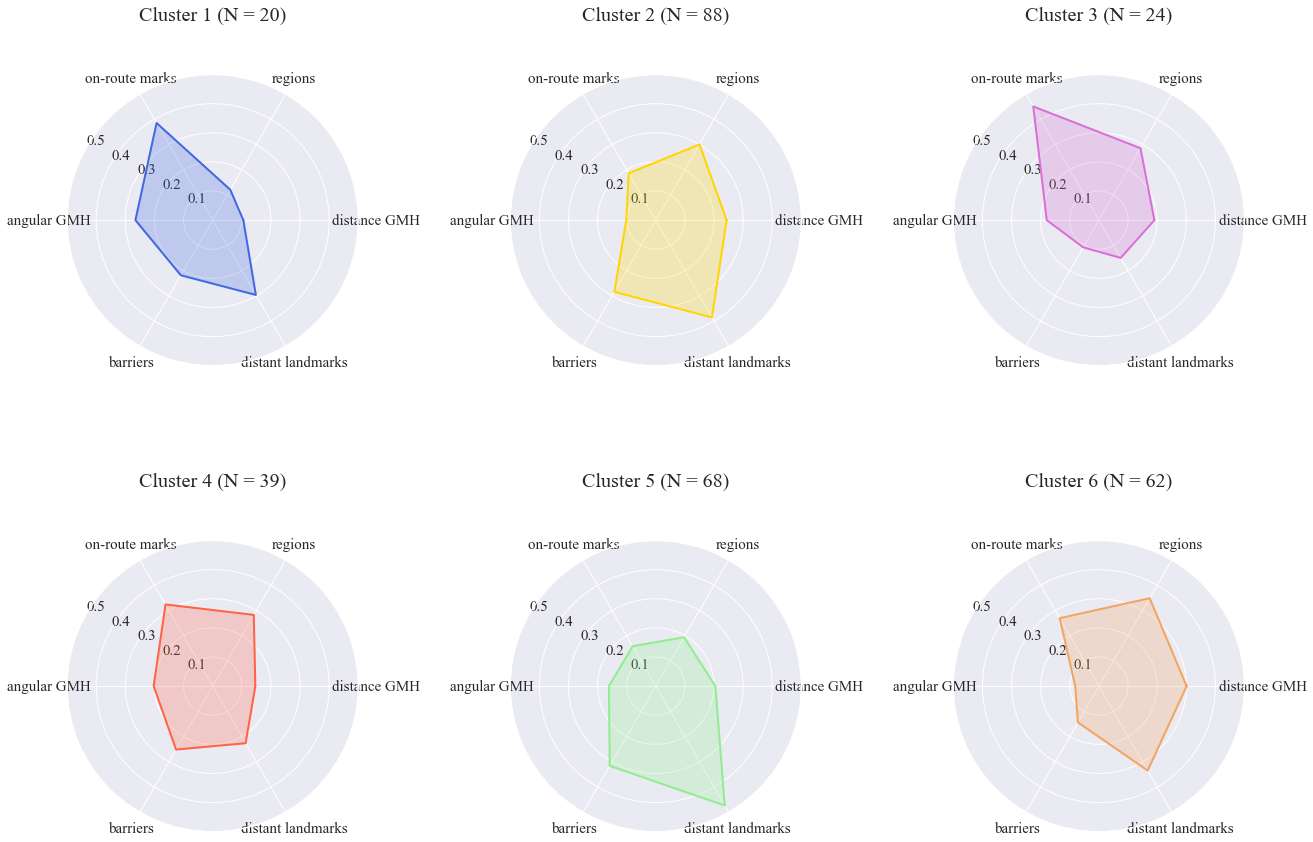

In [79]:
sns.set()
sns.set_color_codes()

colors = ['royalblue', 'gold', 'orchid', 'tomato', 'lightgreen', 'sandybrown', 'sienna', 'darkgreen',
         'c', 'black']

clusters_stats = input_with_cluster.groupby(by = 'cluster').mean()
figsize = (22.5, (15/2*3))
fig = plt.figure(figsize = figsize)
plot_variables = ['onlyDistance',  'regions', 'routeMarks','onlyAngular', 'barriers', 'distantLandmarks']
cluster_v = np.array(plot_variables)
labels = ['distance GMH', 'regions', 'on-route marks','angular GMH', 'barriers', 'distant landmarks'] 

plt.rcParams['font.family'] = 'Times New Roman'
to_plot = list(cluster_stats.index)

for n, cluster in enumerate(to_plot):

    if cluster != 'population':
        tmp = clusters_stats.loc[cluster, cluster_v].values

    angles = np.linspace(0, 2*np.pi, len(labels), endpoint= False)
    
    # close the plot
    tmp = np.concatenate((tmp,[tmp[0]]))
    angles = np.concatenate((angles,[angles[0]]))
    
    if cluster != 'population':
        ax = fig.add_subplot(3, 3,  n+1, polar = True)
        color = colors[cluster-1]
    
    ax.plot(angles, tmp, '-', color = color, linewidth=2)
    ax.fill(angles, tmp, color = color, alpha=0.25)
    ax.set_thetagrids((angles * 180/np.pi)[0:len(plot_variables)], labels, fontsize = 15)
    ax.yaxis.set_ticks([0.10, 0.20, 0.30, 0.40, 0.50])
    ax.tick_params(axis='y', labelsize= 15)
    ax.tick_params(axis='x', labelsize= 15, pad = 5)
    ax.set_rlabel_position(150)
    
    if cluster != 'population':
        nr = len(input_with_cluster[input_with_cluster.cluster == cluster])
        title = "Cluster "+str(cluster) + " (N = "+str(nr)+")"
        
    ax.set_title(title, va = 'bottom', fontsize = 20, pad = 50, fontfamily = 'Times New Roman')

fig.subplots_adjust(wspace=0.20, hspace = 0.60)

In [80]:
fig.savefig("Outputs/Figures/empiricalABM/f5_conference.pdf", bbox_inches='tight')

In [1376]:
raw['cluster'] = labels_cluster
print('Age')
cluster_deom_stats = raw.groupby("cluster")['age'].mean()
print(cluster_deom_stats)
print()

Age
cluster
1   28.032
2   28.176
3   27.217
4   28.642
5   25.429
6   27.935
Name: age, dtype: float64



In [1383]:
print('Gender')
cluster_deom_stats = raw.groupby(["cluster", 'sex'])['sex'].count()
for cluster in range(1, max(labels_cluster)+1):
    print("cluster", cluster)
    for gender in list(cluster_deom_stats.loc[cluster].index):
        print(gender, round(cluster_deom_stats.loc[cluster][gender]/cluster_deom_stats.loc[cluster].sum() *100, 1))
    print()

Gender
cluster 1
female 64.5
male 35.5

cluster 2
female 56.0
male 44.0

cluster 3
female 71.7
male 26.7
non-binary 1.7

cluster 4
female 56.7
male 41.8
non-binary 1.5

cluster 5
female 71.4
male 28.6

cluster 6
female 67.7
male 29.0
prefer not to 3.2



In [1097]:
tab = pd.DataFrame(columns = {'cluster', 'variable', 'value'}) 
labels = ['distance min.', 'angular min.', 'distance LMH', 'angular LMH', 'regions', 
          'on-route marks', 'barriers', 'distant landmarks', 'knowledge']

tab = pd.DataFrame(columns = {'cluster', 'variable', 'value'}) 
index = 0
for subject in input_with_cluster.index:
    for n, variable in enumerate(cluster_variables+['knowledge']):
        tab.at[index, 'variable'] = labels[n]
        tab.at[index, 'cluster'] = "Cluster "+str(int(input_with_cluster.loc[subject]['cluster']))
        tab.at[index, 'value'] = input_with_cluster.loc[subject][variable]
        index += 1

tab['value'] = tab.value.astype(float)
tab.sort_values('cluster', inplace = True)

In [1098]:
import pingouin as pin
pin.pairwise_ttests(data = tab[tab.variable == 'knowledge'], dv= 'value', between = 'cluster')

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,cluster,Cluster 0,Cluster 1,False,True,-1.822,53.046,two-sided,0.074,0.935,-0.372
1,cluster,Cluster 0,Cluster 2,False,True,-1.076,53.485,two-sided,0.287,0.381,-0.247
2,cluster,Cluster 0,Cluster 3,False,True,-2.188,51.472,two-sided,0.033,1.792,-0.498
3,cluster,Cluster 0,Cluster 4,False,True,0.746,44.301,two-sided,0.460,0.355,0.206
4,cluster,Cluster 0,Cluster 5,False,True,0.274,60.000,two-sided,0.785,0.267,0.069
5,cluster,Cluster 1,Cluster 2,False,True,0.995,140.269,two-sided,0.322,0.281,0.159
6,cluster,Cluster 1,Cluster 3,False,True,-0.494,153.129,two-sided,0.622,0.194,-0.077
7,cluster,Cluster 1,Cluster 4,False,True,2.496,31.452,two-sided,0.018,3.458,0.575
8,cluster,Cluster 1,Cluster 5,False,True,1.946,46.900,two-sided,0.058,1.145,0.428
9,cluster,Cluster 2,Cluster 3,False,True,-1.488,123.488,two-sided,0.139,0.516,-0.263


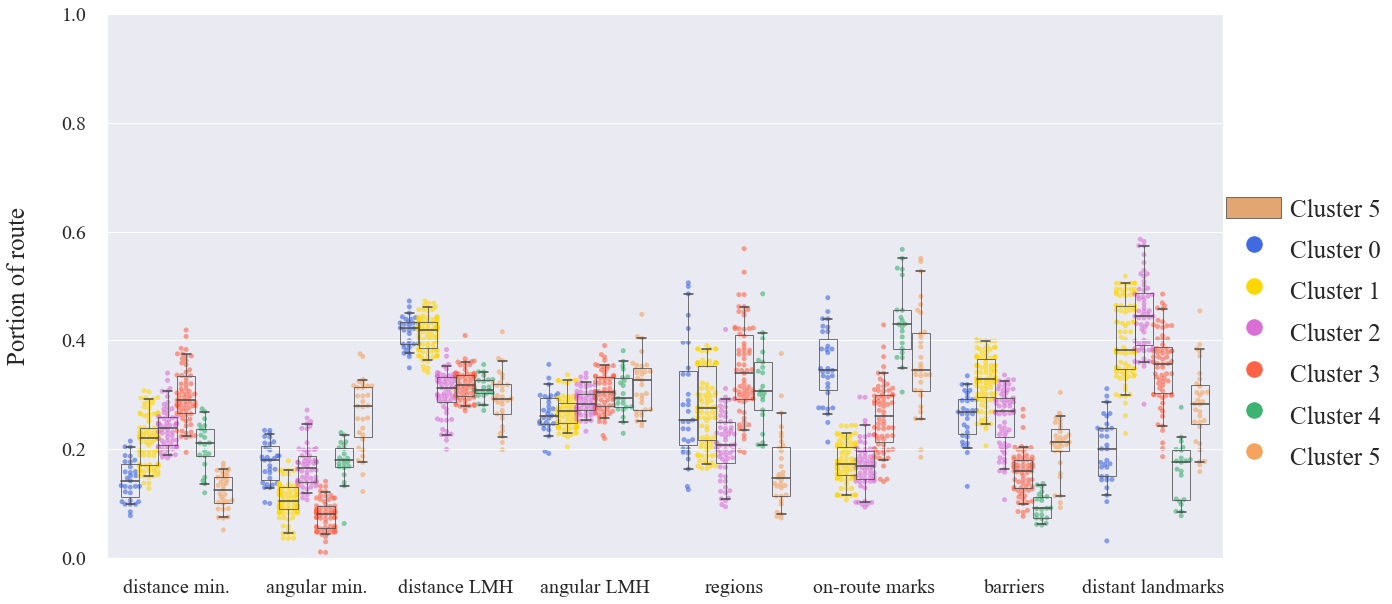

In [1099]:
sns.set()
sns.set_color_codes()

palette = ['royalblue', 'gold', 'orchid', 'tomato', 'mediumseagreen', 'sandybrown', 'sienna', 'darkgreen',
         'c', 'black']
labels = ['distance min.', 'angular min.', 'distance LMH', 'angular LMH', 'regions', 
          'on-route marks', 'barriers', 'distant landmarks']

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 10))
boxprops = dict(alpha=0.75, linewidth = 1)
#     handles,_ = ax.get_legend_handles_labels()

ax = sns.swarmplot(x = 'variable', y ='value', data = tab, hue ='cluster', palette = palette, dodge = True, 
                   alpha = 0.60, s = 5,  zorder = 0, order =labels)
ax = sns.boxplot(x='variable', y='value', hue = 'cluster', data= tab, 
                 palette = palette, whis = [5,95], showfliers = False, boxprops=boxprops, 
                 whiskerprops = boxprops, zorder = 1, order =labels)

for nn, box in enumerate(ax.artists):
    box.set_facecolor('None')

ax.get_legend().remove()
ax.set_ylim(0.0, 1.00)
ax.set_ylabel('Portion of route', fontsize = 25, labelpad = 30, fontfamily = 'Times New Roman')
ax.set_xlabel('', labelpad = 30, fontfamily = 'Times New Roman')

for tick in ax.get_yticklabels(): 
    tick.set_fontname('Times New Roman')
for tick in ax.get_xticklabels(): 
    tick.set_fontname('Times New Roman')
ax.tick_params(axis='both', labelsize= 20, pad = 15) 

ax.legend(frameon=False, markerscale = 2, labelspacing=1.5)
leg = ax.get_legend() 
ax.get_legend().set_title(None)

handles, labels = ax.get_legend_handles_labels()
legend = plt.legend(handles[5:], labels[5:], markerscale= 2, labelspacing=1.5, frameon = False)
plt.setp(legend.texts, family='Times New Roman', fontsize = 25, va = 'center')

legend.get_frame().set_linewidth(0.0) # remove legend border
legend.get_frame().set_facecolor('none')
legend.set_bbox_to_anchor((0.82, 0.36, 0.33, 0.33))

In [469]:
fig.savefig("Outputs/Figures/empiricalABM/f6.pdf", bbox_inches='tight')

## Final input data for ABM

In [1103]:
columns = []
for column in input_with_cluster.columns:
    if column in ['knowledge', 'cluster']:
        continue
    columns.append(column+"_mean")
    columns.append(column+"_std")
    
groups = ['group'+str(cluster) for cluster in input_with_cluster['cluster'].unique()]
indexes = groups + ['population', 'nullGroup']
clusters_gdf = pd.DataFrame(index = indexes, columns = columns)
variables = route_variables
# element_variables = ['regions', 'routeMarks', 'barriers', 'distantLandmarks']

clusters = input_with_cluster['cluster'].unique()
for index in indexes:
    for variable in variables:
        if index not in ['population', 'nullGroup']:
            cluster = int(index[5:])
            clusters_gdf.at[index, variable+'_mean'] = input_with_cluster[input_with_cluster.cluster == cluster][variable].mean()
            clusters_gdf.at[index, variable+'_std'] = input_with_cluster[input_with_cluster.cluster == cluster][variable].std()
        else:
            clusters_gdf.at[index, variable+'_mean'] = input_with_cluster[variable].mean()
            clusters_gdf.at[index, variable+'_std'] = input_with_cluster[variable].std()
    
    if index not in ['population', 'nullGroup']:
        cluster = int(index[5:])
        clusters_gdf.at[index, 'portion'] = len(input_with_cluster[input_with_cluster.cluster == cluster])/len(input_with_cluster)
    else:
        clusters_gdf.at[index, 'portion'] = 1.00

In [1106]:
clusters_gdf

,usingElements_mean,usingElements_std,noElements_mean,noElements_std,onlyDistance_mean,onlyDistance_std,onlyAngular_mean,onlyAngular_std,distanceHeuristic_mean,distanceHeuristic_std,...,routeMarks_std,barriers_mean,barriers_std,distantLandmarks_mean,distantLandmarks_std,preferenceNatural_mean,preferenceNatural_std,aversionSevering_mean,aversionSevering_std,portion
group1,0.68,0.042,0.32,0.042,0.214,0.045,0.106,0.031,0.412,0.031,...,0.035,0.328,0.046,0.404,0.068,0.504,0.212,0.52,0.306,0.302
group2,0.59,0.04,0.41,0.04,0.24,0.037,0.17,0.038,0.303,0.04,...,0.044,0.258,0.053,0.446,0.066,0.504,0.262,0.46,0.285,0.199
group3,0.624,0.044,0.376,0.044,0.298,0.05,0.078,0.028,0.319,0.027,...,0.061,0.156,0.04,0.351,0.066,0.5,0.219,0.642,0.279,0.223
group0,0.682,0.046,0.318,0.046,0.143,0.037,0.175,0.038,0.415,0.029,...,0.067,0.26,0.045,0.196,0.063,0.46,0.183,0.517,0.28,0.103
group4,0.616,0.046,0.384,0.046,0.206,0.044,0.178,0.037,0.313,0.021,...,0.071,0.095,0.024,0.16,0.054,0.435,0.188,0.5,0.273,0.070
group5,0.613,0.065,0.387,0.065,0.123,0.033,0.265,0.063,0.293,0.048,...,0.093,0.206,0.05,0.282,0.071,0.476,0.205,0.557,0.338,0.103
population,0.639,0.058,0.361,0.058,0.221,0.07,0.141,0.068,0.351,0.062,...,0.105,0.24,0.087,0.35,0.112,0.491,0.219,0.537,0.299,1.000
nullGroup,0.639,0.058,0.361,0.058,0.221,0.07,0.141,0.068,0.351,0.062,...,0.105,0.24,0.087,0.35,0.112,0.491,0.219,0.537,0.299,1.000


In [1109]:
for n, column in enumerate(clusters_gdf.columns):
    print(n+1, column)

1 usingElements_mean
2 usingElements_std
3 noElements_mean
4 noElements_std
5 onlyDistance_mean
6 onlyDistance_std
7 onlyAngular_mean
8 onlyAngular_std
9 distanceHeuristic_mean
10 distanceHeuristic_std
11 angularHeuristic_mean
12 angularHeuristic_std
13 regions_mean
14 regions_std
15 routeMarks_mean
16 routeMarks_std
17 barriers_mean
18 barriers_std
19 distantLandmarks_mean
20 distantLandmarks_std
21 preferenceNatural_mean
22 preferenceNatural_std
23 aversionSevering_mean
24 aversionSevering_std
25 portion


In [1111]:
clusters_gdf.to_csv('Outputs/empiricalABM/'+city_name+'_clustersII.csv')
# routes_stats.to_csv('Outputs/empiricalABM/'+city_name+'_routes_stats.csv')